In [22]:
import json, glob, csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# If you're in Jupyter, uncomment:
%matplotlib inline

LOG_DIR = Path('../logs/eval')
# LOG_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_CSV = Path('../logs/eval_summary.csv')

print(f'[INFO] Will read eval runs from: {LOG_DIR.resolve()}')


[INFO] Will read eval runs from: C:\unistuff\Fall25\Topics\tetris\logs\eval


In [23]:
def load_json_file(path: Path):
    """
    Return list[dict] from a saved eval JSON file, or None if unreadable.
    """
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        if isinstance(data, list) and len(data) > 0:
            return data
    except Exception as e:
        print(f"[WARN] failed to load {path}: {e}")
    return None


def to_array(data, key):
    """
    Extract numeric series for a given key from the list of per-episode dicts.
    Missing/invalid -> np.nan.
    """
    vals = []
    for d in data:
        if key in d:
            try:
                vals.append(float(d[key]))
            except Exception:
                vals.append(np.nan)
        else:
            vals.append(np.nan)
    return np.array(vals, dtype=float)


def safe_masked_pair(x, y):
    """
    Keep only pairs where both x and y are finite, so plots don't break.
    """
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]


def summarize_run(name, data):
    """
    Produce summary stats for one run (one eval JSON file).
    """
    ep      = to_array(data, 'episode')
    rew     = to_array(data, 'reward')
    length  = to_array(data, 'length')
    lines   = to_array(data, 'lines') if any('lines' in d for d in data) else np.array([])

    summary = {
        'run': name,
        'episodes_logged': int(len(data)),
        'reward_mean':    float(np.nanmean(rew)) if rew.size else np.nan,
        'reward_max':     float(np.nanmax(rew)) if rew.size else np.nan,
        'length_mean':    float(np.nanmean(length)) if length.size else np.nan,
        'length_max':     float(np.nanmax(length)) if length.size else np.nan,
        'lines_mean':     float(np.nanmean(lines)) if lines.size else np.nan,
        'lines_max':      float(np.nanmax(lines)) if lines.size else np.nan,
    }
    return summary


def plot_reward_curves(runs_dict):
    """
    Plot reward vs episode for each run on the same axes.
    """
    plt.figure(figsize=(7,4))
    for run_name, data in runs_dict.items():
        ep  = to_array(data, 'episode')
        rew = to_array(data, 'reward')
        x_clean, y_clean = safe_masked_pair(ep, rew)
        if x_clean.size:
            plt.plot(x_clean, y_clean, label=run_name)
    plt.title('Reward vs Episode (All Runs)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def plot_length_curves(runs_dict):
    """
    Plot episode length vs episode for each run on the same axes.
    Episode length ~= survival time in steps in Tetris.
    """
    plt.figure(figsize=(7,4))
    for run_name, data in runs_dict.items():
        ep   = to_array(data, 'episode')
        lng  = to_array(data, 'length')
        x_clean, y_clean = safe_masked_pair(ep, lng)
        if x_clean.size:
            plt.plot(x_clean, y_clean, label=run_name)
    plt.title('Episode Length vs Episode (All Runs)')
    plt.xlabel('Episode')
    plt.ylabel('Episode Length (steps survived)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def plot_lines_hist(run_name, data):
    """
    If the 'lines' metric exists (e.g. lines cleared in Tetris),
    show its distribution for that run.
    """
    lines = to_array(data, 'lines')
    finite_lines = lines[np.isfinite(lines)]
    if not finite_lines.size:
        return

    plt.figure(figsize=(6,4))
    plt.hist(finite_lines, bins=20, edgecolor='black')
    plt.title(f'Lines Cleared Distribution — {run_name}')
    plt.xlabel('Lines per Episode')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    print(f"[INFO] {run_name}: mean lines {np.nanmean(finite_lines):.2f}, max {np.nanmax(finite_lines):.0f}")


In [24]:
runs = {}
for path_str in glob.glob(str(LOG_DIR / '*.json')):
    p = Path(path_str)
    data = load_json_file(p)
    if data:
        runs[p.stem] = data

print(f"[INFO] Loaded {len(runs)} runs:", list(runs.keys()))
if not runs:
    print("No runs found. You may need to run src.eval first to generate logs/eval/*.json.")


[INFO] Loaded 4 runs: ['tetris-a2c-explorer-7', 'tetris-a2c-survivor-7', 'tetris-ppo-explorer-7', 'tetris-ppo-survivor-7']


In [30]:
summaries = [summarize_run(name, data) for name, data in runs.items()]
df_summary = pd.DataFrame(summaries)
df_summary


,run,episodes_logged,reward_mean,reward_max,length_mean,length_max,lines_mean,lines_max
0,tetris-a2c-explorer-7,124,3.431548,5.010992,84.709677,103.0,0.080645,1.0
1,tetris-a2c-survivor-7,155,3.440383,5.377394,72.374194,110.0,0.051613,1.0
2,tetris-ppo-explorer-7,31,3.336597,5.010992,90.419355,103.0,0.129032,1.0
3,tetris-ppo-survivor-7,217,3.390950,5.087393,88.400922,105.0,0.142857,1.0


In [26]:
if len(df_summary) > 0:
    df_summary.to_csv(SUMMARY_CSV, index=False)
    print('[OK] wrote summary CSV ->', SUMMARY_CSV.resolve())
else:
    print('[WARN] no data to save to summary CSV')


[OK] wrote summary CSV -> C:\unistuff\Fall25\Topics\tetris\logs\eval_summary.csv


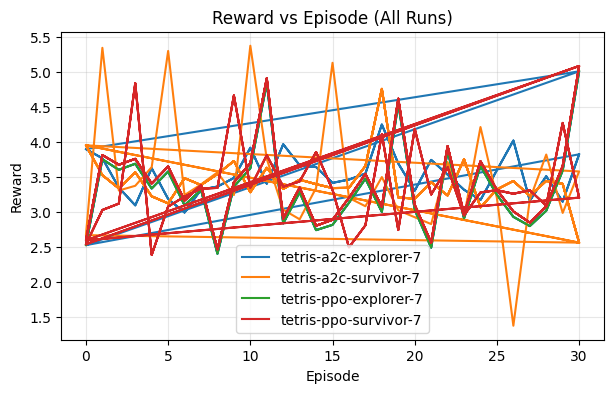

In [27]:
if runs:
    plot_reward_curves(runs)
else:
    print('[WARN] nothing to plot for reward curves')


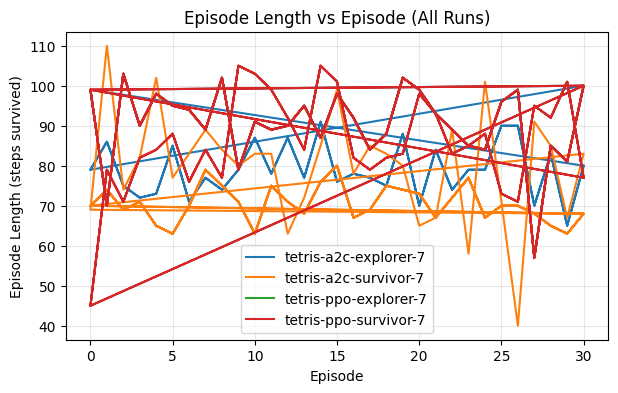

In [28]:
if runs:
    plot_length_curves(runs)
else:
    print('[WARN] nothing to plot for length curves')


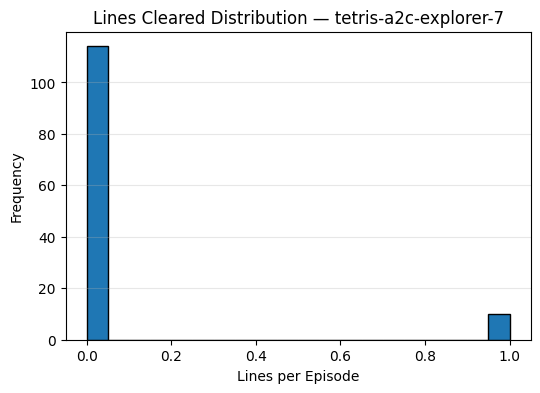

[INFO] tetris-a2c-explorer-7: mean lines 0.08, max 1


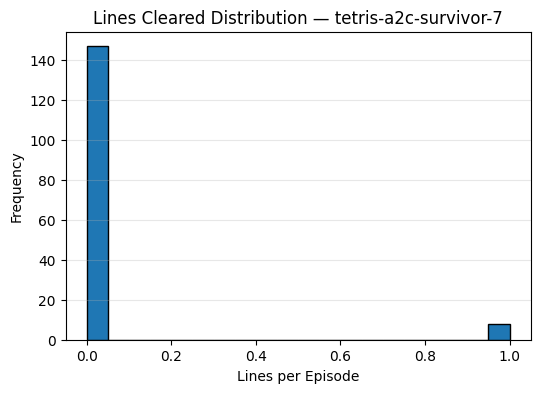

[INFO] tetris-a2c-survivor-7: mean lines 0.05, max 1


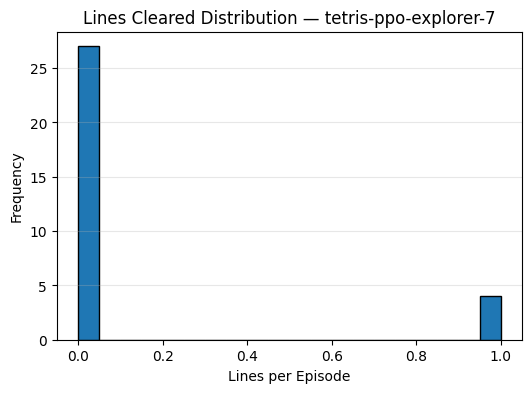

[INFO] tetris-ppo-explorer-7: mean lines 0.13, max 1


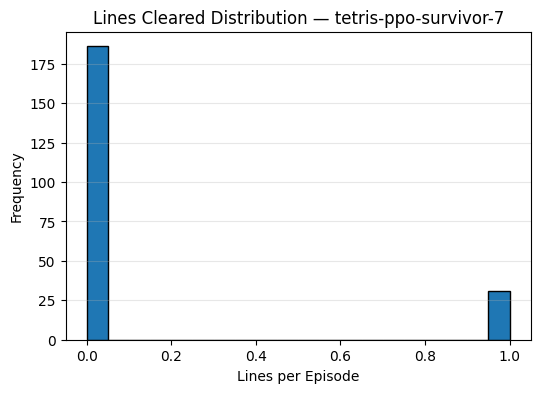

[INFO] tetris-ppo-survivor-7: mean lines 0.14, max 1


In [29]:
if runs:
    for run_name, data in runs.items():
        plot_lines_hist(run_name, data)
else:
    print('[WARN] nothing to plot for line distributions')
